# Rešavanje sistema linearnih jednačina na kvantnom računaru

Postoji nekoliko algoritama za rešavanje sistema linearnih jednačina na kvantnom računaru.

## Rešavanje korišćenjem algoritma QAOA

In [1]:
import numpy as np
from numpy import linalg as la

A = np.array([[1, 2, 3, 0], [4, 5, 6, 0], [7, 8, 9, 0], [0, 0, 0, 0]])

b = np.array([0, 1, 0, 0])

c = la.norm(b)

b = b / c

print(A)
print(b)
print(c)

[[1 2 3 0]
 [4 5 6 0]
 [7 8 9 0]
 [0 0 0 0]]
[0. 1. 0. 0.]
1.0


In [2]:
from math import sqrt

X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
Op = 1/2.0 * (X + 1j*Y)
Om = 1/2.0 * (X - 1j*Y)

def make_hermitian(A, b):
    A1 = np.kron(Op, A) + np.kron(Om, A.conj().T)
    b1 = np.kron(np.array([0, 1]), b)
    return (A1, b1)

def make_positive_definite(A, b):
    n = b.size
    t_row = np.kron(np.array([1/sqrt(2.0), 1/sqrt(2.0)]), b).reshape(1, 2*n)
    t_col = t_row.reshape(-1, 1)
    Qb = np.eye(2*n) - np.matmul(t_col, t_row)
    H0 = np.kron(Op, np.matmul(np.kron(Z, np.eye(n)), Qb)) + np.kron(Om, np.matmul(Qb, np.kron(Z, np.eye(n))))
    H1 = np.kron(Op, np.matmul(np.kron(X, A), Qb)) + np.kron(Om, np.matmul(Qb, np.kron(X, A)))

    return (H0, H1)

A1, b1 = make_hermitian(A, b)
H0, H1 = make_positive_definite(A1, b1)

In [3]:
from qiskit.quantum_info import SparsePauliOp

cost_hamiltonian, mixer_hamiltonian = SparsePauliOp.from_operator(H1), SparsePauliOp.from_operator(H0)

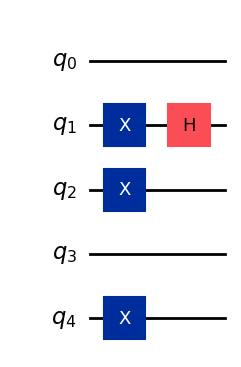

In [4]:
from qiskit.circuit import QuantumCircuit

b_oracle = QuantumCircuit(2)
b_oracle.x(1)

b1_oracle = QuantumCircuit(3)
b1_oracle.x(0)
b1_oracle = b1_oracle.compose(b_oracle, [1, 2])

final_oracle = QuantumCircuit(5)
final_oracle.x(1)
final_oracle.h(1)
final_oracle = final_oracle.compose(b1_oracle, [2, 3, 4])

final_oracle.draw("mpl")

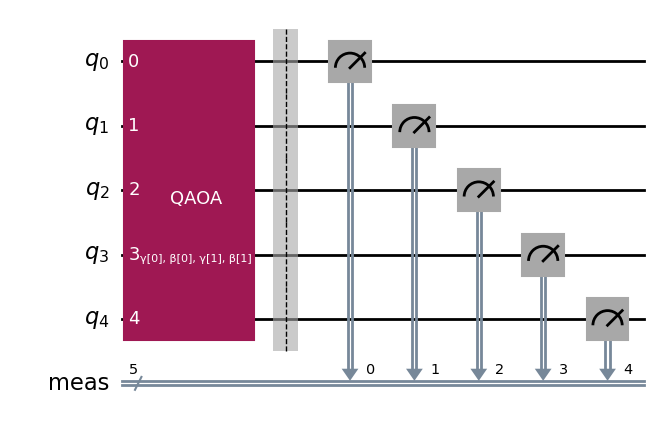

In [5]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, mixer_operator = mixer_hamiltonian, reps = 2, initial_state = final_oracle)
circuit.measure_all()

circuit.draw("mpl")

In [6]:
initial_gamma = np.pi
initial_beta = np.pi / 2
init_params = [initial_beta, initial_beta, initial_gamma, initial_gamma]

squared_hamiltonian = cost_hamiltonian & cost_hamiltonian

In [7]:
def cost_func_estimator(params, ansatz, hamiltonian, squared, estimator):
    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = squared.apply_layout(ansatz.layout)
 
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])
 
    results = job.result()[0]
    cost = results.data.evs
 
    objective_func_vals.append(cost)

    print(cost)
 
    return cost

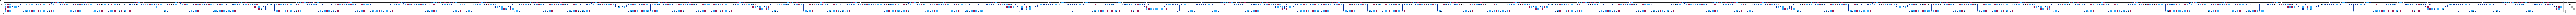

In [8]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler

service = QiskitRuntimeService(channel = 'local')
backend = service.least_busy()
print(backend)
 
# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
 
candidate_circuit = pm.run(circuit)
candidate_circuit.draw("mpl", fold=False, idle_wires=False)

In [9]:
from scipy.optimize import minimize

objective_func_vals = []  # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000
 
    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, squared_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

65.27697302697302
65.80669330669332
67.49350649350644
66.95679320679318
64.75199800199795
67.02197802197801
65.22352647352646
65.97002997003
67.65559440559441
62.514485514485486
64.96903096903104
64.04845154845161
66.66083916083915
67.3628871128872
62.715034965034995
67.7102897102897
64.60989010989016
60.260739260739236
63.22827172827174
67.36288711288711
62.33341658341651
67.43331668331672
62.29995004995006
64.04020979020974
54.927822177822165
72.1565934065934
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 72.1565934065934
       x: [ 1.445e+00  1.478e+00  2.967e+00  4.148e+00]
    nfev: 26
   maxcv: 0.0


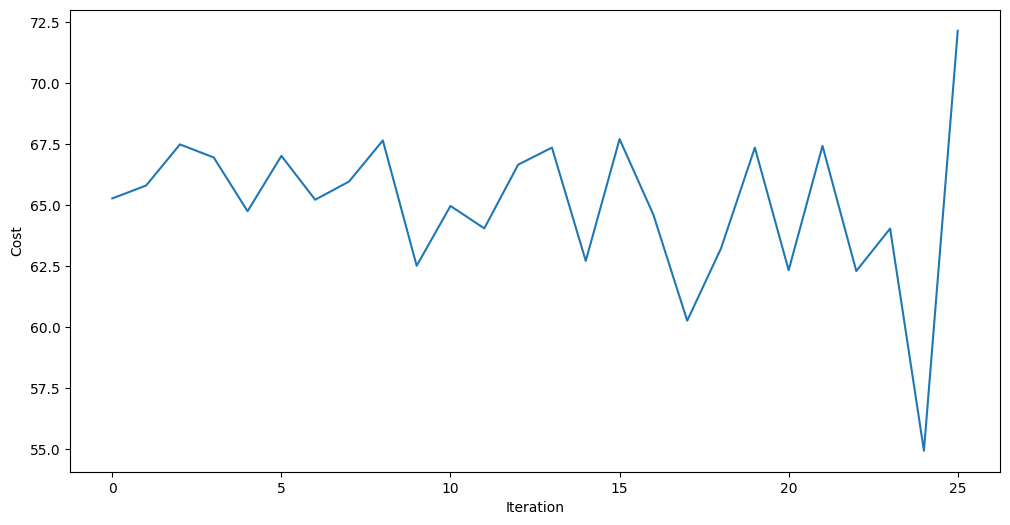

In [10]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [15]:
ansatz = QAOAAnsatz(cost_operator=cost_hamiltonian, mixer_operator = mixer_hamiltonian, reps = 2, initial_state = final_oracle)

In [16]:
parameters = np.array([1.445e+00,  1.478e+00,  2.967e+00,  4.148e+00])

In [19]:
from qiskit.quantum_info import Statevector

bound_ansatz = ansatz.assign_parameters(parameters)

# Simulate the statevector produced by the bound ansatz
x = Statevector(bound_ansatz)

# x1 = |1> |x>
# x2 = |0> |+> |1> |x>

x.draw("latex")

<IPython.core.display.Latex object>